<a href="https://colab.research.google.com/github/m-dabo/derivatives/blob/main/Deriv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Codebook for open classroom
#### based on Derivatives Analytics by Y. H.

# General Requirements

In [13]:
# Packages
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt

# Customization
mpl.rcParams['font.family'] = 'serif'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Part I : The Market

## Ch. 2: Market based valuation

Text(0, 0.5, 'Option value')

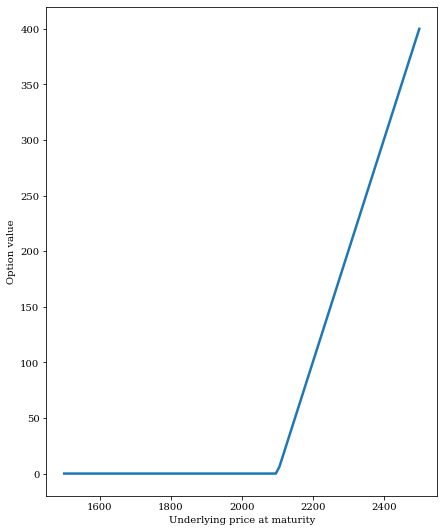

In [ ]:
# Defining prices
K = 2100 # strike price
S = np.linspace(1500, 2500, 100) # underlying price vector
h = np.maximum(S - K, 0) # call option inner values

# Visualization
plt.figure(figsize = (7, 9))
plt.plot(S, h, lw = 2.5) # plot inner values at maturity
plt.xlabel('Underlying price at maturity')
plt.ylabel('Option value')

## Ch. 3: Market Stylized Facts

### Normality of (log-)returns of prices 

**Returns from price process simulated with GBM (BSM model)**


In [14]:
## Density function
def dN(x, mu, sigma):
  '''
  Probability density function of a normal random variable.
  
  Parameters
  ==========
  mu (float) : expected value
  sigma (float) : standard deviation
  
  Returns
  =======
  pdf (float) : value of proba density function
  '''
  z = (x - mu) / sigma
  pdf = np.exp(-.5 * z ** 2) / np.sqrt(2 * np.pi * sigma ** 2)
  return pdf

In [20]:
## Price simulation
def simulate_BSM():
  # model parameters
  S0 = 100.0 # initial index level
  T = 10.0 # time horizon
  r = .05 # risk-free short rate
  vol = .2 # instataneous volatility

  # simulation parameters
  np.random.seed(1000)
  dates = pd.date_range(start  = '30-09-2004',
                           end = '30-09-2014',
                           freq = 'B')
  M = len(dates) # time steps
  I = 1 # index level paths (one path in this case)
  dt = 1 / 252.0 # fixed for simplicity
  df = np.exp(-r * dt) # discount factor

  # stock price paths
  rand = np.random.standard_normal((M, I)) # random numbers
  S = np.zeros_like(rand) # stock matrix
  S[0] = S0 # initialization
  for i in range(1, M) : # stock price paths
    S[i] = S[i - 1] * np.exp((r - vol ** 2 / 2) * dt
                             + vol * rand[i] * np.sqrt(dt))
  BSM = pd.DataFrame(S[:, 0], index = dates, columns = ['quotes'])
  BSM['returns'] = np.log(BSM['quotes'] / BSM['quotes'].shift(1)) 

  # realized volatility
  BSM['rea_var'] = 252 * np.cumsum(BSM['returns'] ** 2) / np.arange(len(BSM))
  BSM['rea_vol'] = np.sqrt(BSM['rea_var'])
  BSM = BSM.dropna()

  return BSM

In [21]:
data = simulate_BSM()

In [25]:
## Sample statistics and normality tests
def print_stats(data) :
  print('----------------------------------------------------')
  print('Mean of daily log returns :', np.mean(data['returns']))
  print('Std of daily log returns :', np.std(data['returns']))
  print('Mean of annualized log returns :', 
        np.mean(data['returns']) * 252)
  print('Std of annualized log returns :', 
        np.std(data['returns']) * np.sqrt(252))
  print('----------------------------------------------------')
  print('Skew of sample log returns :', 
        scs.skew(data['returns']))
  print('Skew normal test p-value :', 
        scs.skewtest(data['returns'])[1])
  print('----------------------------------------------------')
  print('Kurtosis of sample log returns :',
        scs.kurtosis(data['returns']))
  print('Kurtosis normal test p-value :',
        scs.kurtosistest(data['returns'])[1])
  print('----------------------------------------------------')
  print('Normal test p-value :', 
        scs.normaltest(data['returns'])[1])
  print('----------------------------------------------------')
  print('Realized variance :', data['rea_var'].iloc[-1])
  print('Realized volatility :', data['rea_vol'].iloc[-1])  

In [26]:
print_stats(data)

----------------------------------------------------
Mean of daily log returns : -4.7091117372038534e-05
Std of daily log returns : 0.01281560140528586
Mean of annualized log returns : -0.01186696157775371
Std of annualized log returns : 0.20344136532069765
----------------------------------------------------
Skew of sample log returns : -0.0912713057375048
Skew normal test p-value : 0.056857998950421436
----------------------------------------------------
Kurtosis of sample log returns : -0.015745336369699547
Kurtosis normal test p-value : 0.9245931789761545
----------------------------------------------------
Normal test p-value : 0.1623743895210439
----------------------------------------------------
Realized variance : 0.041388947952030054
Realized volatility : 0.20344273875474164


**Graphical output**

In [29]:
## Daily quotes and log returns
def quotes_returns(data) :
  ''' Plot index daily quotes and returns'''
  plt.figure(figsize = (10, 8))
  plt.subplot(211)
  data['quotes'].plot()
  plt.ylabel('daily quotes')
  plt.axis('tight')
  plt.subplot(212)
  data['returns'].plot()
  plt.ylabel('daily log returns')
  plt.axis

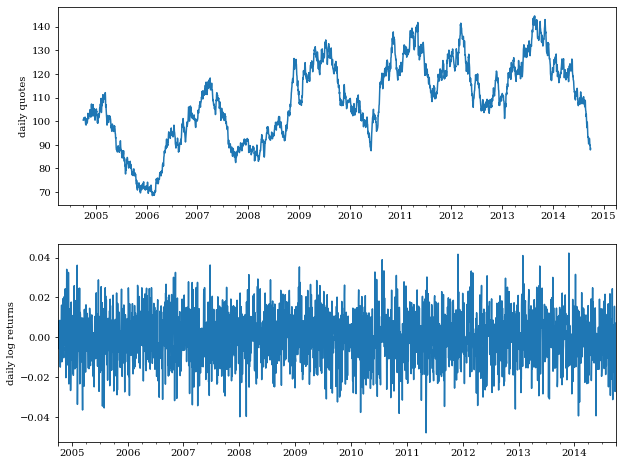

In [30]:
quotes_returns(data)

In [38]:
## Histogram of annualized returns
def return_hist(data) : 
  ''' Plot a histogram of the log returns'''
  plt.figure(figsize = (10, 8))
  plt.hist(np.array(data['returns']), bins = 50, density = True)
  # normal pdf
  x = np.linspace(min(data['returns']), max(data['returns']),
                  100) 
  y = dN(x, np.mean(data['returns']), np.std(data['returns']))
  plt.plot(x, y, lw = 2)
  plt.xlabel('log returns')
  plt.ylabel('frequency/probability')

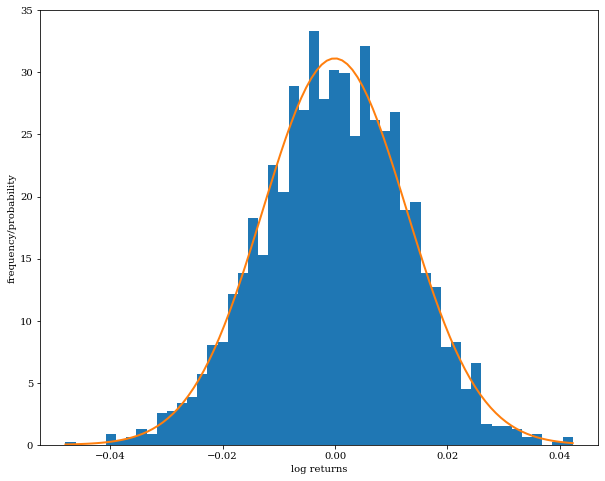

In [39]:
return_hist(data)

In [42]:
## Q-Q plot of annualized log returns
def return_qqplot(data) :
  ''' Generate a q-q plot of the log returns'''
  plt.figure(figsize = (10, 8))
  sm.qqplot(data['returns'], line = 's')
  plt.xlabel('theoretical quantiles')
  plt.ylabel('sample quantiles')

<Figure size 720x576 with 0 Axes>

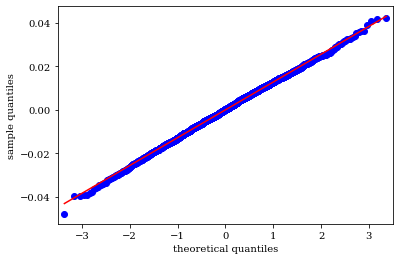

In [43]:
return_qqplot(data)

In [44]:
## Realized volatility
def real_vol(data) :
  ''' Plot the realized volatility'''
  plt.figure(figsize = (10, 8))
  data['rea_vol'].plot()
  plt.ylabel('realized volatility')

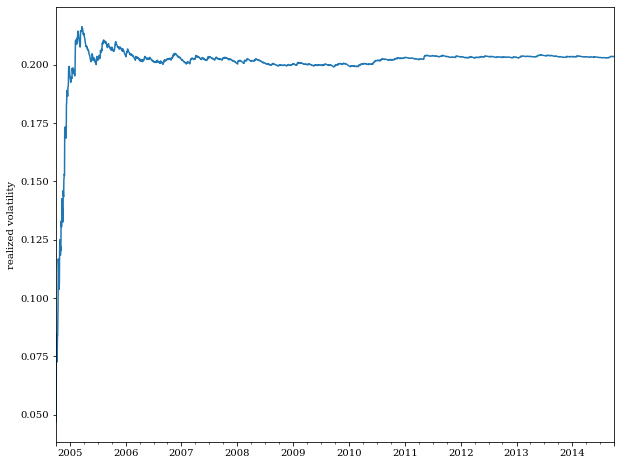

In [45]:
real_vol(data)

In [46]:
## Rolling statistics
def rolling_stats(data) :
  '''Calculate and plot rolling statistics 
         (252 days moving = 1 year)'''
  plt.figure(figsize = (10, 8))

  plt.subplot(311)
  rol_mean = pd.rolling_mean(data['returns'], 252) * 252
  rol_mean.plot()
  plt.ylabel('returns moving average (252d)')
  plt.axhline(rol_mean.mean(), color = 'r', ls = 'dashed',
              lw = 1.5)
  
  plt.subplot(312)
  rol_std = pd.rolling_std(data['returns'], 252) * np.sqrt(252)
  rol_std.plot()
  plt.ylabel('volatility moving average (252d)')
  plt.axhline(rol_std.mean(), color = 'r', ls = 'dashed',
              lw = 1.5)
  vx = plt.axis()

  plt.subplot(313)
  rol_cor = pd.rolling_corr(rol_mean, rol_std, 252)
  rol_cor.plot()
  plt.ylabel('Correlation')
  cx = plt.axis()
  plot.axis([vx[0], vx[1], vx[2], cx[3]])
  plt.axhline(rol_cor.mean(), color = 'r', ls = 'dashed',
              lw = 1.5)



### Indices and Stocks

#### Stylized Facts

In [ ]:
## Stochastic Volatility

In [2]:
## Volatility Clustering

In [3]:
## Volatility Mean Reversion

In [4]:
## Leverage effect

In [5]:
## Fat tails

In [6]:
## Jumps

### Option Markets

In [7]:
## Bid/Ask spread

In [8]:
## Implied Volatility Surface

### Smiles


### Term structures


### Short Rates

In [9]:
## Positivity

In [10]:
## Stochasticity

In [11]:
## Mean reversion

In [12]:
## Term structure